# Subsampling of Tahoe Dataset
# Predicting drug perturbations using RDKit embeddings for drugs

# Imports

In [26]:
import io
import pandas as pd
import scanpy as sc
import pyarrow.dataset as ds
import gcsfs
import os
import numpy as np
import ast

# Functions

In [ ]:
# List Files in Google Cloud Storage Bucket

def print_gc_files(fs):
    # List the top‐level contents of the bucket
    print(fs.ls('arc-ctc-tahoe100'))

    # Drill down into a folder:
    print(fs.ls('arc-ctc-tahoe100/2025-02-25'))

    # List everything recursively:
    all_files = fs.find('arc-ctc-tahoe100')
    print(len(all_files), "items found")
    for file in all_files:
        print(file)

# Calculate Total Remote File Size in GCS

def calc_remote_file_size(fs, h5ad_file):
    all_paths = fs.find(h5ad_file)

    # Sum up file sizes
    total_bytes = 0
    for path in all_paths:
        print(path)
        info = fs.info(path)
        if info.get('type') == 'file':
            total_bytes += info.get('size', 0)

    # Print result in bytes and GB
    print(f"Total size: {total_bytes:,} bytes")
    print(f"Which is roughly {total_bytes/1e9:.2f} GB")
    

# Parse Drug Condition Identifier   
def parse_condition(s):
    parsed = ast.literal_eval(s)
    if len(parsed) == 0:
        raise ValueError(f"Condition {s} is empty")
    compound, dose, unit = parsed[0]
    x = f"{compound}_{dose}{unit}"
    x = x.replace('.', '')
    return x

# Extract Numerical Dose from Condition String
def get_dose_from_condition(s):
    parsed = ast.literal_eval(s)
    if len(parsed) == 0:
        raise ValueError(f"Condition {s} is empty")
    compound, dose, unit = parsed[0]
    return float(dose)

# Read the data and subsample

In [ ]:
# Download the h5ad file from google storage # mounts Google Cloud Storage via gcsfs and downloads the file
local_file  = "plate9_full.h5ad"
if not os.path.exists(local_file):
    # Initialize GCS file system for reading data from GCS
    fs = gcsfs.GCSFileSystem()
    
    # File to Download and use
    h5ad_file = 'arc-ctc-tahoe100/2025-02-25/h5ad/plate9_filt_Vevo_Tahoe100M_WServicesFrom_ParseGigalab.h5ad'
    
    # print_gc_files(fs)
    # calc_remote_file_size(fs, h5ad_file)

    print(f"Downloading {h5ad_file} → {local_file} …")
    fs.get(h5ad_file, local_file)
    print("Download complete.")
else:
    print(f"Local file '{local_file}' already exists; skipping download.")    # Otherwise, if the backed file already exists, it skips the download.


# Open in backed mode (only obs. and var. loaded into RAM, the rest of the expression matrix is on the disc)
print("Reading all data...")
adata_full = sc.read_h5ad(local_file, backed="r")  
print("-> Total cells on Plate 9:", adata_full.n_obs) 


# Define which cell line to use
target_cell_line = "CVCL_0459"   # <--- change this to your cell line name

# Get index of cell line
mask_cell_line = adata_full.obs['cell_line'] == target_cell_line

# Build control and drug masks on the full object
ctrl_mask = adata_full.obs['drug'].str.contains(r"\bDMSO_TF\b|\bDMSO\b", case=False, na=False)  
treated_mask = ~ctrl_mask                                                               #The inverse of control (~ctrl_mask) is considered drug-treated

# Only keep drug/dose conditions within the target cell line. Filter Treated Conditions Within Target Cell Line
mask_treated_cell_line = treated_mask & mask_cell_line
drug_conds = adata_full.obs.loc[mask_treated_cell_line, "drugname_drugconc"].unique().tolist()

# Stratified Subsampling of Treated Cells per Condition
N_per_drug = 300                                #<--------choose the number N of cells per drug you want to keep!
control_percentage = ctrl_mask[mask_cell_line].mean()  # percentage among selected cell line/Proportional Subsampling of DMSO Controls

# Sample indices for treated within cell line
sampled_idxs = []
for index, cond in enumerate(drug_conds):
    idxs = np.where((adata_full.obs["drugname_drugconc"] == cond) & mask_cell_line)[0]
    n_to_pick  = min(len(idxs), N_per_drug)
    pick = np.random.choice(idxs, size=n_to_pick, replace=False)
    sampled_idxs.append(pick)

# Sample controls within cell line
ctrl_idxs = np.where(ctrl_mask & mask_cell_line)[0]
N_ctrl = int(np.ceil(N_per_drug * len(drug_conds) * control_percentage))    # ceil = round up to nearest integer
n_to_pick = min(len(ctrl_idxs), N_ctrl)
ctrl_pick = np.random.choice(ctrl_idxs, size=n_to_pick, replace=False)
sampled_idxs.append(ctrl_pick)

#Combine Indices and Subset the Backed Object
all_idxs   = np.concatenate(sampled_idxs)

adata_sub  = adata_full[all_idxs, :].to_memory()
print("Subset shape:", adata_sub.shape)


Local file 'plate9_full.h5ad' already exists; skipping download.
Reading all data...
-> Total cells on Plate 9: 5866669
Subset shape: (28774, 62710)


# Data Preprocessing for CPA

In [ ]:
# Inspect and Copy Subsampled Data
print(adata_sub)
adata_sub_log = adata_sub.copy()
adata_sub_log.layers['counts'] = adata_sub_log.X.copy()

# Check Cell Distribution per Drug Condition
print("\nCells per drug condition:")
print(adata_sub_log.obs["drugname_drugconc"].value_counts())

# Add CPA-Specific Observation Keys
adata_sub_log.obs["condition_ID"] = adata_sub_log.obs["drugname_drugconc"].apply(parse_condition)
print("\nCondition IDs:\n", adata_sub_log.obs["condition_ID"])

# Extract and Log-Transform Drug Dose
adata_sub_log.obs["dose"] = adata_sub_log.obs["drugname_drugconc"].apply(get_dose_from_condition)

print("\nDoses (µM):\n", adata_sub_log.obs["dose"])

adata_sub_log.obs['log_dose'] = np.log10(adata_sub_log.obs['dose'] + 1e-6)
print("\nLog - Doses (µM):\n", adata_sub_log.obs["log_dose"])

# Create Composite Covariate Column
print("\n-> Adding cell_type and cov_drug_dose column...")
adata_sub_log.obs["cell_type"] = adata_sub_log.obs["cell_line"]
adata_sub_log.obs["cov_drug_dose"] = (
    adata_sub_log.obs["cell_line"].astype(str)
    + "|" +
    adata_sub_log.obs["condition_ID"].astype(str)
    + "|" +
    adata_sub_log.obs["log_dose"].astype(str)
)
print("-> Done.")


# Filter out cells with low number of counts
before = adata_sub_log.n_obs
sc.pp.filter_cells(adata_sub_log, min_counts=100)
after = adata_sub_log.n_obs
print(f" Filtered cells based on min_counts ≥ 100:")
print(f"   • Before filtering: {before} cells")
print(f"   • After filtering:  {after} cells")
print(f"   • Cells removed:    {before - after}")

print("\n ➜ Sample of remaining cells:")
print(adata_sub_log.obs.head())

# Normalize counts to 10k UMIs per cell
print("-> Normalizing...")
sc.pp.normalize_total(adata_sub_log, target_sum=1e4, exclude_highly_expressed=False)
    
# Log-transform
print("-> Log transforming...")
sc.pp.log1p(adata_sub_log)

# Select HVGs (2 000 genes)
print("-> Highly Variable Genes...")
sc.pp.highly_variable_genes(adata_sub_log, n_top_genes=2000, subset=True)


AnnData object with n_obs × n_vars = 28774 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'

Cells per drug condition:
drugname_drugconc
[('DMSO_TF', 0.0, 'uM')]                         665
[('Adagrasib', 0.05, 'uM')]                      300
[('(S)-Crizotinib', 5.0, 'uM')]                  300
[('Afatinib', 5.0, 'uM')]                        300
[('Almonertinib (mesylate)', 5.0, 'uM')]         300
                                                ... 
[('Tranilast', 5.0, 'uM')]                       300
[('Verteporfin', 5.0, 'uM')]                     300
[('Verapamil', 5.0, 'uM')]                       300
[('crizotinib', 5.0, 'uM')]                      300
[('Trametinib (DMSO_TF solvate)', 5.0, 'uM')]    209
Name: count, Length: 95, dtype: int64

Condition IDs:
 BARCODE_SUB_LIB_ID
01_155_162-lib_2502    Sivelestat (s

In [46]:
#Compute Differential Expression per Drug Condition (vs. DMSO Control) for RDKit-Based Modeling
adata_sub_log.raw = adata_sub_log                               
print("-> Compute DE per condition...")
sc.tl.rank_genes_groups(
    adata_sub_log,
    groupby='condition_ID',       
    reference='DMSO_TF_00uM',     # control id
    method='t-test_overestim_var',
    key_added='rank_genes_groups',
    use_raw=True
)

-> Compute DE per condition...


c:\Users\maritina\anaconda3\envs\scbasecount-py\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\maritina\anaconda3\envs\scbasecount-py\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\maritina\anaconda3\envs\scbasecount-py\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:434: P

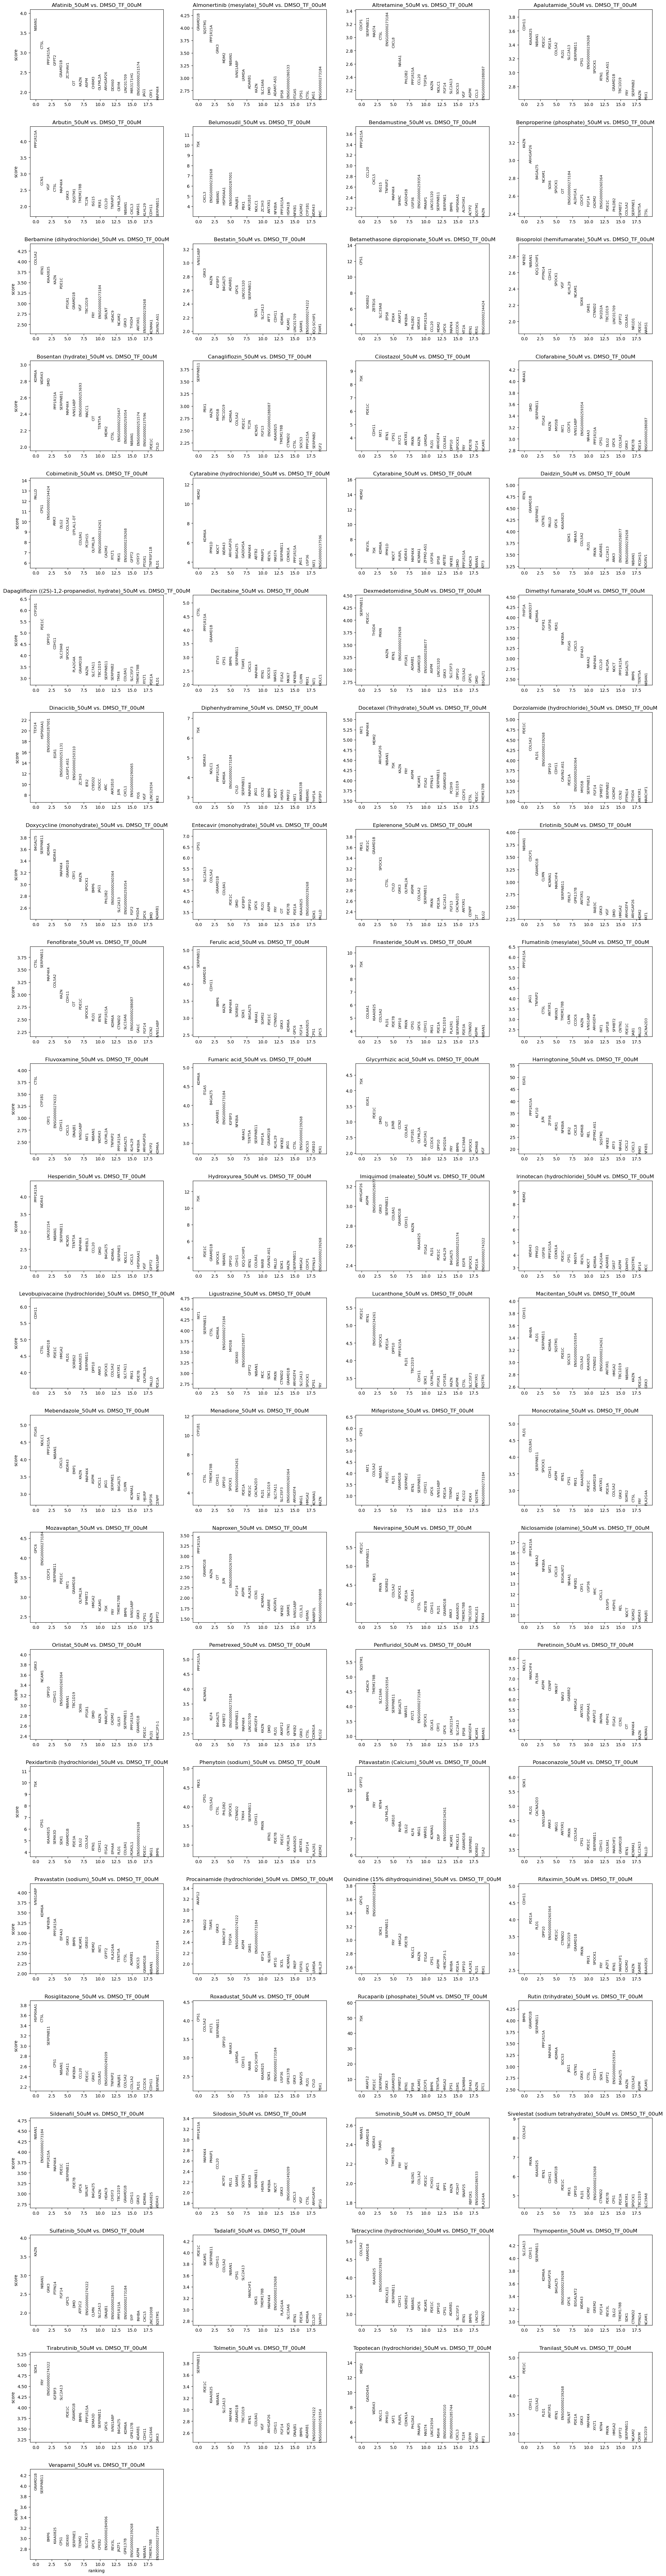

In [47]:
#check the results
sc.pl.rank_genes_groups(adata_sub_log, n_genes=20, sharey=False)


In [48]:
top_genes = adata_sub_log.uns['rank_genes_groups']['names']
print(top_genes)  # Will show genes per group (drug condition)


[('NIBAN1', 'GRAMD1B', 'CDCP1', 'CDH11', 'PPP1R15A', '7SK', 'PPP1R15A', 'KAZN', 'COL5A2', 'IVNS1ABP', 'CPS1', 'NFKB2', 'KDM6A', 'SERPINB11', '7SK', 'NR4A1', 'PALLD', 'MDM2', 'MDM2', 'RTN1', 'CYP1B1', 'CTSL', 'SERPINB11', 'FHIP1A', 'TEX14', '7SK', 'FAT1', 'PDE1C', 'B4GALT5', 'CPS1', 'PBX1', 'NIBAN1', 'CTSL', 'SERPINB11', '7SK', 'PPP1R15A', 'CTSL', 'KDM6A', '7SK', 'EGR1', 'PPP1R15A', '7SK', 'ARHGAP26', 'MDM2', 'CDH11', 'FAT1', 'PDE1C', 'CDH11', 'ITGA5', 'CYP1B1', 'CPS1', 'PLD1', 'GPC6', 'PPP1R15A', 'PDE1C', 'CXCL2', 'GRK3', 'PPP1R15A', 'SQSTM1', 'NOLC1', '7SK', 'PBX1', 'GFPT2', 'SDK1', 'IVNS1ABP', 'AKAP12', 'GPC6', 'CDH11', 'HSP90AA1', 'CPS1', '7SK', 'BMP6', 'NIBAN1', 'PPP1R15A', 'NIBAN1', 'COL5A2', 'KAZN', 'PDE1C', 'COL5A2', 'SLC2A13', 'SDK1', 'SERPINB11', 'MDM2', 'PDE1C', 'GRAMD1B')
 ('CTSL', 'SQSTM1', 'SERPINB11', 'KIAA0825', 'CCN1', 'CXCL3', 'CCL20', 'ARHGAP26', 'RTN1', 'GRK3', 'SORBS2', 'NIBAN1', 'WDR43', 'PBX1', 'PDE1C', 'DMD', 'CPS1', 'KDM6A', 'REV3L', 'GRAMD1B', 'PDE1C', 'PPP1R15

In [49]:
import re

def clean_name(name):
    # Lowercase
    name = name.lower()
    # Remove common salt forms & hydrates
    name = re.sub(r'\s*\(.*?\)', '', name)
    name = name.replace(' hydrochloride', '')
    name = name.replace(' diacetate', '')
    name = name.replace(' sulfate', '')
    name = name.replace(' hemihydrate', '')
    name = name.replace(' acetate', '')
    name = name.replace(' sodium', '')
    # Remove Greek letters
    name = name.replace('β', 'beta')
    name = name.replace('α', 'alpha')
    name = name.replace('δ', 'delta')
    name = name.replace('γ', 'gamma')
    # Remove symbols and spaces
    name = re.sub(r'[^a-z0-9]', '', name)
    return name

# Apply it
adata_sub_log.obs['drug_cleaned'] = adata_sub_log.obs['drug'].apply(clean_name)

# Inspect
print("Cleaned drug names (first 100):")
print(adata_sub_log.obs['drug_cleaned'].unique()[:100])

Cleaned drug names (first 100):
['sivelestat' 'posaconazole' 'tetracycline' 'entecavir' 'sildenafil'
 'dimethylfumarate' 'berbamine' 'daidzin' 'fumaricacid' 'pravastatin'
 'almonertinib' 'irinotecan' 'rucaparib' 'dinaciclib' 'bosentan'
 'bestatin' 'tadalafil' 'belumosudil' 'flumatinib' 'cytarabine' 'afatinib'
 'topotecan' 'naproxen' 'lucanthone' 'benproperine' 'erlotinib'
 'fenofibrate' 'rutin' 'pexidartinib' 'tirabrutinib' 'diphenhydramine'
 'harringtonine' 'phenytoin' 'orlistat' 'monocrotaline' 'finasteride'
 'hydroxyurea' 'doxycycline' 'pitavastatin' 'cobimetinib' 'simotinib'
 'procainamide' 'silodosin' 'nevirapine' 'cilostazol' 'dorzolamide'
 'roxadustat' 'canagliflozin' 'decitabine' 'ligustrazine' 'thymopentin'
 'hesperidin' 'mebendazole' 'betamethasonedipropionate' 'levobupivacaine'
 'rosiglitazone' 'quinidine' 'verapamil' 'bisoprolol' 'penfluridol'
 'ferulicacid' 'pemetrexed' 'fluvoxamine' 'bendamustine' 'altretamine'
 'rifaximin' 'dexmedetomidine' 'menadione' 'glycyrrhizicacid'

In [50]:
from datasets import load_dataset   ##### pip install datasets on terminal
import pandas as pd

drug_meta = load_dataset("tahoebio/Tahoe-100M", "drug_metadata", split="train")
df = pd.DataFrame(drug_meta)

# Keep only needed columns
smiles_mapping = df[['drug', 'canonical_smiles']].drop_duplicates()

Resolving data files:   0%|          | 0/3388 [00:00<?, ?it/s]

In [51]:
def normalize(name):
    return name.lower().replace(" ", "").replace("-", "").replace("(", "").replace(")", "").replace(",", "").replace("'", "").strip()

# Apply to both dataframes
adata_sub_log.obs['drug_norm'] = adata_sub_log.obs['drug'].apply(normalize)
smiles_mapping['drug_norm'] = smiles_mapping['drug'].apply(normalize)

In [52]:
# Create dictionary for mapping
smiles_dict = dict(zip(smiles_mapping['drug_norm'], smiles_mapping['canonical_smiles']))

# Map SMILES
adata_sub_log.obs['smiles_rdkit'] = adata_sub_log.obs['drug_norm'].map(smiles_dict)

# Convert to category
adata_sub_log.obs['smiles_rdkit'] = adata_sub_log.obs['smiles_rdkit'].astype('category')

# Check if 'CS(=O)C' is in categories; add if missing
if 'CS(=O)C' not in adata_sub_log.obs['smiles_rdkit'].cat.categories:
    adata_sub_log.obs['smiles_rdkit'] = adata_sub_log.obs['smiles_rdkit'].cat.add_categories(['CS(=O)C'])

# Assign to all DMSO rows (robust to naming like 'DMSO_TF_00uM')
adata_sub_log.obs.loc[adata_sub_log.obs['drug'].str.lower().str.contains('dmso'), 'smiles_rdkit'] = 'CS(=O)C'

# Final check
print("✅ Missing SMILES:", adata_sub_log.obs['smiles_rdkit'].isna().sum())
print("✅ Mapped SMILES:", adata_sub_log.obs['smiles_rdkit'].notna().sum())

✅ Missing SMILES: 0
✅ Mapped SMILES: 26165


In [53]:
print(set(adata_sub_log.obs['drug']))

{'Finasteride', 'Sivelestat (sodium tetrahydrate)', 'Canagliflozin', 'Monocrotaline', 'Fluvoxamine', 'Penfluridol', 'Thymopentin', 'Bosentan (hydrate)', 'Menadione', 'Cilostazol', 'Nevirapine', 'Entecavir (monohydrate)', 'Benproperine (phosphate)', 'Quinidine (15% dihydroquinidine)', 'Flumatinib (mesylate)', 'Almonertinib (mesylate)', 'Bestatin', 'Rifaximin', 'Rosiglitazone', 'Apalutamide', 'Dinaciclib', 'Roxadustat', 'Imiquimod (maleate)', 'Cytarabine', 'Phenytoin (sodium)', 'Tranilast', 'Orlistat', 'Cytarabine (hydrochloride)', 'Bendamustine', 'Fumaric acid', 'Berbamine (dihydrochloride)', 'Clofarabine', 'Sildenafil', 'Arbutin', 'Bisoprolol (hemifumarate)', 'Pexidartinib (hydrochloride)', 'Betamethasone dipropionate', 'Eplerenone', 'Doxycycline (monohydrate)', 'Mebendazole', 'Tetracycline (hydrochloride)', 'Levobupivacaine (hydrochloride)', 'Niclosamide (olamine)', 'Dapagliflozin ((2S)-1,2-propanediol, hydrate)', 'Ferulic acid', 'Tirabrutinib', 'Rucaparib (phosphate)', 'Lucanthone', 

In [54]:
print("Number of DMSO controls kept:", (adata_sub_log.obs['drug_cleaned'] == 'dmsotf').sum())
print("Any DMSO as solvent left?", adata_sub_log.obs[adata_sub_log.obs['smiles_rdkit'] == 'CS(=O)C']['drug_cleaned'].unique())


Number of DMSO controls kept: 665
Any DMSO as solvent left? ['dmsotf']


In [55]:
mask_dmso = adata_sub_log.obs['drug_cleaned'] == 'dmsotf'  # Use your actual DMSO label
mask_not_dmso_smiles = adata_sub_log.obs['smiles_rdkit'] != 'CS(=O)C'  # Only non-DMSO molecules

# Keep either DMSO controls OR all valid (non-DMSO) drugs
adata_sub_log = adata_sub_log[mask_dmso | mask_not_dmso_smiles].copy()

In [56]:
adata_sub_log = adata_sub_log[adata_sub_log.obs['smiles_rdkit'].notna()].copy()
print(f"→ Final AnnData with SMILES shape: {adata_sub_log.shape}")

→ Final AnnData with SMILES shape: (26165, 2000)


In [57]:
multi_smiles = adata_sub_log.obs.groupby('smiles_rdkit')['condition_ID'].nunique()
nonunique_smiles = multi_smiles[multi_smiles > 1].index.tolist()

if len(nonunique_smiles) > 0:
    print(f" {len(nonunique_smiles)} SMILES are associated with multiple conditions:")
    for smiles in nonunique_smiles:
        print(f"  - {smiles}: used by {multi_smiles[smiles]} conditions")
    # Optionally: print which condition_IDs are mapped to that SMILES
    for smiles in nonunique_smiles:
        conds = adata_sub_log.obs.loc[adata_sub_log.obs['smiles_rdkit'] == smiles, 'condition_ID'].unique()
        print(f"    SMILES {smiles} → {conds}")
else:
    print(" All SMILES are uniquely mapped to conditions.")




 All SMILES are uniquely mapped to conditions.


C:\Users\maritina\AppData\Local\Temp\ipykernel_14824\1157025192.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  multi_smiles = adata_sub_log.obs.groupby('smiles_rdkit')['condition_ID'].nunique()


In [58]:
# List of non-unique SMILES (from your printout)
nonunique_smiles = [
    "CC(C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N=C3)C4CCNCC4)N",
    "CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O.Cl",
    "CN1CCCC1COC2=NC3=C(CCN(C3)C4=CC=CC5=C4C(=CC=C5)Cl)C(=N2)N6CCN(C(C6)CC#N)C(=O)C(=C)F",
]

# Remove all cells with these SMILES
adata_sub_log = adata_sub_log[~adata_sub_log.obs['smiles_rdkit'].isin(nonunique_smiles)].copy()

print(f" Filtered AnnData shape: {adata_sub_log.shape}")
print("Unique SMILES remaining:", adata_sub_log.obs['smiles_rdkit'].nunique())


 Filtered AnnData shape: (26165, 2000)
Unique SMILES remaining: 86


In [59]:
# # Group by condition and get the first SMILES value per condition
condition_smiles = adata_sub_log.obs[['condition_ID', 'smiles_rdkit']].drop_duplicates()

# # Sort alphabetically for readability (optional)
condition_smiles = condition_smiles.sort_values(by='condition_ID')

# # Display
for cond, smile in condition_smiles.values:
    print(f"{cond}: {smile}")


Afatinib_50uM: CN(C)CC=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C3)F)Cl)OC4CCOC4
Almonertinib (mesylate)_50uM: CN(C)CCN(C)C1=CC(=C(C=C1NC(=O)C=C)NC2=NC=CC(=N2)C3=CN(C4=CC=CC=C43)C5CC5)OC.CS(=O)(=O)O
Altretamine_50uM: CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C
Apalutamide_50uM: CNC(=O)C1=C(C=C(C=C1)N2C(=S)N(C(=O)C23CCC3)C4=CC(=C(N=C4)C#N)C(F)(F)F)F
Arbutin_50uM: C1=CC(=CC=C1O)OC2C(C(C(C(O2)CO)O)O)O
Belumosudil_50uM: CC(C)NC(=O)COC1=CC=CC(=C1)C2=NC3=CC=CC=C3C(=N2)NC4=CC5=C(C=C4)NN=C5
Bendamustine_50uM: CN1C2=C(C=C(C=C2)N(CCCl)CCCl)N=C1CCCC(=O)O
Benproperine (phosphate)_50uM: CC(COC1=CC=CC=C1CC2=CC=CC=C2)N3CCCCC3.OP(=O)(O)O
Berbamine (dihydrochloride)_50uM: CN1CCC2=CC(=C3C=C2C1CC4=CC=C(C=C4)OC5=C(C=CC(=C5)CC6C7=C(O3)C(=C(C=C7CCN6C)OC)OC)O)OC.Cl.Cl
Bestatin_50uM: CC(C)CC(C(=O)O)NC(=O)C(C(CC1=CC=CC=C1)N)O
Betamethasone dipropionate_50uM: CCC(=O)OCC(=O)C1(C(CC2C1(CC(C3(C2CCC4=CC(=O)C=CC43C)F)O)C)C)OC(=O)CC
Bisoprolol (hemifumarate)_50uM: C.CC(C)NCC(COC1=CC=C(C=C1)COCCOC(C)C)O.C(=CC(=O)O)C(=O)O
Bosenta

In [60]:
# ─── 11) Save the downsampled, balanced subset ───────────────────────────────
# 8) Now save your CPA-ready subset
save_path = "plate9_RDkit_for_CPA_CVCL_0459_300.h5ad"              
adata_sub_log.write_h5ad(save_path)
print(f"Wrote fully preprocessed AnnData to: {save_path}")

Wrote fully preprocessed AnnData to: plate9_RDkit_for_CPA_CVCL_0459_300.h5ad
